<a href="https://colab.research.google.com/github/7ZXU/AI/blob/main/HandsOnMachineLearning/HandsOnCH15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

# SET UP

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# **15.3 시계열 예측하기**

시계열 데이터는 시간적 순서를 가지는 데이터이다

예:주식 가격, 날씨 데이터 등등

RNN 모델을 이용해 예측할 시계열을 임의로 만들 수 있다

In [ ]:
# 임의의 단변량 시계열 생성 함수 

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps) # 타임 스탭 길이의 직선 생성
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 사인곡선1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # 사인곡선2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # 잡음추가
    return series[..., np.newaxis].astype(np.float32)

(3, 10, 1)


<function matplotlib.pyplot.show>

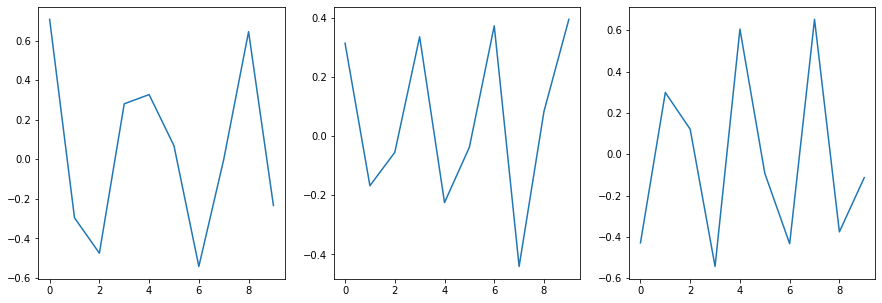

In [ ]:
# 생성된 시계열 데이터 시각화
batch_size_test = 3 # 샘플 데이터 3개
time_step_test = 10 # 주식데이터라면 10일간의 데이터

series_test = generate_time_series(batch_size_test,time_step_test)
print(series_test.shape)

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i in range(3):
    axes[i].plot(series_test[i,:,:])
plt.show

In [ ]:
np.random.seed(42)

n_steps = 50 # 타임스텝 = 50
series = generate_time_series(10000, n_steps + 1) 
# 배치크기 = 10000 
# n_steps + 1 # 50일의 주식 데이터를 입력해 마지막날 하루를 예측한다 # 여기서 +1은 예측하는 하루를 의미한다
series.shape


(10000, 51, 1)

In [ ]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # 샘플수 =70000 # X_train : n_steps 0~50 # y_train : n_steps 51
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [ ]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [ ]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

## **15.3.1 기준 성능 (Baseline Performance)**

RNN 모델의 성능을 판단하기 위해 

판단의 기준이 되는 성능을 준비해놓는다

### 순진한(단순한) 예측

시계열의 마지막 값을 예측한 값이라 여긴다

In [ ]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

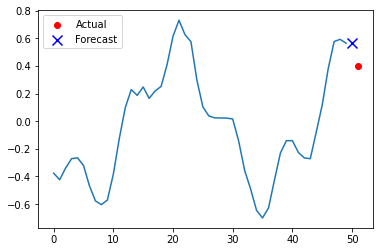

In [ ]:
plt.plot(X_valid[0,:,0]) # X_valid 첫번째 시계열 데이터 그리기
plt.scatter(n_steps +1, y_valid[0,0], c='r', label='Actual') # 실제값
plt.scatter(n_steps, y_pred[0,0], marker='x', s=100, c='b', label='Forecast') # y_valid 예측값(시계열 마지막값)
plt.legend(fontsize=10)
plt.show()

### 선형 회기 모델 예측

FC layer 네트워크 

: Flatten 사용

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), # flatten
    keras.layers.Dense(1) # 출력
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 4ms/step - loss: 0.1221 - val_loss: 0.0335
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0270 - val_loss: 0.0155
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0096
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0046

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0037


0.0037077832967042923

## **15.3.2 간단한 RNN 구현하기**

- 하나의 층으로 이루어진 RNN 모델 
- tanh 활성화 함수 사용
- 모델 파라미터 = 3


In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, return_sequences=False, input_shape=[None, 1]) 
    # SimpleRNN # 메모리셀 만들어주는 모듈 
    # 기본적으로 tanh 활성화 함수가 있기에 따로 지정할 필요가 없다

    # return_sequences=False # 최종 출력만 반환

    # input_shape=[None, 1]
    # None # 입력 시퀀스 길이가 상관없음 
])

print(model.summary())
# model parameter 3개 # Wx, Wy, Wh

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 12s 49ms/step - loss: 0.7513 - val_loss: 0.3629
Epoch 2/20
219/219 [==============================] - 11s 48ms/step - loss: 0.3194 - val_loss: 0.1972
Epoch 3/20
219/219 [==============================] - 10s 48ms/step - loss: 0.1707 - val_loss: 0.1510
Epoch 4/20
219/219 [==============================] - 10s 48ms/step - loss: 0.1488 - val_loss: 0.1556
Epoch 5/20
219/219 [==============================] - 10s 48ms/step - loss: 0.1451 - val_loss: 0.1491
Epoch 6/20
219/219 [==============================] - 10s 48ms/step - loss: 0.1444 - val_loss: 0.1471
Epoch 7/20
219/219 [=================

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0129


0.012889636680483818

### return sequence
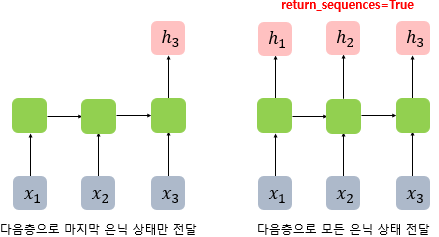

- return_sequences = False 

최종 ouput만 출력

- return_sequences = True 

은닉층값까지 출력

In [ ]:
# return_sequences 출력 비교
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, return_sequences=False, input_shape=[3, 1]) 
    # SimpleRNN # 메모리셀 만들어주는 모듈 
    # 기본적으로 tanh 활성화 함수가 있기에 따로 지정할 필요가 없다

    # return_sequences=False # 최종 출력만 반환

    # input_shape=[None, 1]
    # None # 입력 시퀀스 길이가 상관없음 
])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


## **15.3.3 Deep RNN**

RNN 한 층으로는 성능이 좋지 않다는 것을 확인하고 

메모리셀 층을 더 쌓아 성능을 개선하고자 했다

In [ ]:
# SimpleRNN(20, ) 
# 20은 유닛이며 은닉상태의 크기를 의미한다 
# 은닉상태 출력값의 차원과 같다

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
print(model.summary())
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, None, 20)          440       
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, None, 20)          820       
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 31s 134ms/step - loss: 0.0130 - val_loss: 0.0036
Epoch 2/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 28s 129ms/ste

### 마지막층 은닉상태 제거 

마지막 층은 하나의 값을 출력하기만 하면 된다 

즉 마지막 층에서는 순환할 필요가 없다 

따라서 SimpleRNN(순환층)을 Dense Layer로 바꾼다 

Dense Layer로 변환했기에 
- 새로운 활성화 함수를 사용할 수 있다 

    keras.layers.Dense(1, activation='tanh')

- 정확도 및 속도 또한 개선된다

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences=True 제거 # 마지막 층이 dense로 변환했기에 은닉층 결과값을 전달하지 않아도 되기 때문이다
    keras.layers.Dense(1, activation='tanh')
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 22s 91ms/step - loss: 0.0419 - val_loss: 0.0048
Epoch 2/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 5/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/20
219/219 [==============================] - 19s 88ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/20
219/219 [==============================] - 19s 89ms/step - loss: 0.002

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0028


0.002796688349917531

## **15.3.4 여러 타임 스탭 앞 예측하기**

지금까지는 50일의 데이터로 다음 하루를 예측했으나 

이제는 50일의 데이터로 n일 후의 데이터를 예측해볼 것이다

### 방법1. 한 번에 1 스텝 씩 10 스텝 앞 예측

In [ ]:
series = generate_time_series(1, n_steps + 10) # 타임스텝 = 50 + 10
X_new, Y_new = series[:, :n_steps], series[:, n_steps:] # X_new 0~49 #Y_new 50~59
X = X_new


In [ ]:
# 하나의 값을 예측하는 모델로 총 10개의 값 예측
# 0~49 -> 50 예측
# 1~50 -> 51 예측
# 2~51 -> 52 예측 ...
# 9~58 -> 59 예측 (총 10개의 예측값)
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]


In [ ]:
Y_pred.shape

(1, 10, 1)

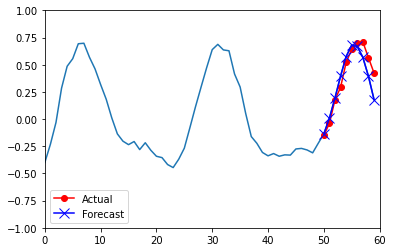

In [ ]:
plt.plot(X[0, :, 0])
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "ro-", label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
plt.axis([0, n_steps + 10, -1, 1])
plt.legend(fontsize=10)
plt.show()

# 오차값이 누적되는 문제 발생

### 방법2. 다음 10개의 값을 한 번에 예측

- 50개의 타임 스탭을 이용해서 다음 10개의 타임 스탭값 예측

- 타깃이 10개의 타임 스탭 값을 지닌 벡터여야 한다 

- 0 ~ 49 (학습) -> 50 ~ 59 (예측)

In [ ]:
n_steps = 50

series = generate_time_series(10000, n_steps + 10) # 타임 스탭 = 50+10

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] # y 타깃을 마지막 10개 값으로 설정
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) # 타깃이 크기 10 벡터로 바뀌었기 때문에 
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 21s 92ms/step - loss: 0.1042 - val_loss: 0.0282
Epoch 2/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0244 - val_loss: 0.0207
Epoch 3/20
219/219 [==============================] - 19s 89ms/step - loss: 0.0182 - val_loss: 0.0146
Epoch 4/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 5/20
219/219 [==============================] - 20s 91ms/step - loss: 0.0137 - val_loss: 0.0120
Epoch 6/20
219/219 [==============================] - 20s 89ms/step - loss: 0.0124 - val_loss: 0.0115
Epoch 7/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0117 - val_loss: 0.0153
Epoch 8/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0114 - val_loss: 0.0117
Epoch 9/20
219/219 [==============================] - 20s 90ms/step - loss: 0.0109 - val_loss: 0.0114
Epoch 10/20
219/219 [==============================] - 20s 90ms/step - loss: 0.010

In [ ]:
model.evaluate(X_test, Y_test) # 모델 평가할 때는 test 값 써주기

32/32 [==============================] - 0s 10ms/step - loss: 0.2795


0.2794504761695862

### 방법3. 모든 타임 스탭에서 다음 값 10개 예측

시퀀스 to 시퀀스 

타임스탭 0 -> 1 ~ 10 예측

타임스탭 1 -> 2 ~ 11 예측

...

타임스탭 49 -> 50 ~ 59 예측

따라서 0 ~ 59 (총 60) 값을 가지게 된다
 

In [ ]:
n_steps = 50
 
series = generate_time_series(10000, n_steps + 10) # 타임스텝 = 50+10

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

X_train.shape

(7000, 50, 1)

In [ ]:
Y = np.empty((10000, n_steps, 10))

# 타임스텝 0 -> 1 ~ 10 예측
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

Y_train.shape # 각 타임 스텝당 출력 크기 10

(7000, 50, 10)

In [ ]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # return_sequences=True # 시퀀스 to 시퀀스 모델
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # 모듈 TimeDistributed # 모든 타임 스텝에서 출력을 적용하기 위해 사용
])

# 사용자 정의 지표 
# 훈련을 위해서는 모든 출력에 걸쳐 MSE 계산
# 평가를 위해서는 마지막 타임 스탭의 출력에 대한 MSE만 계산
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 24s 101ms/step - loss: 0.0642 - last_time_step_mse: 0.0548 - val_loss: 0.0401 - val_last_time_step_mse: 0.0249
Epoch 2/20
219/219 [==============================] - 21s 97ms/step - loss: 0.0388 - last_time_step_mse: 0.0253 - val_loss: 0.0345 - val_last_time_step_mse: 0.0227
Epoch 3/20
219/219 [==============================] - 21s 97ms/step - loss: 0.0341 - last_time_step_mse: 0.0211 - val_loss: 0.0286 - val_last_time_step_mse: 0.0142
Epoch 4/20
219/219 [==============================] - 21s 98ms/step - loss: 0.0282 - last_time_step_mse: 0.0138 - val_loss: 0.0258 - val_last_time_step_mse: 0.0111
Epoch 5/20
219/219 [==============================] - 22s 98ms/step - loss: 0.0255 - last_time_step_mse: 0.0116 - val_loss: 0.0226 - val_last_time_step_mse: 0.0088
Epoch 6/20
219/219 [==============================] - 22s 98ms/step - loss: 0.0234 - last_time_step_mse: 0.0100 - val_loss: 0.0242 - val_last_time_step_mse: 0.0116
Epoch 7/20
219/

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0180 - last_time_step_mse: 0.0065


[0.017983999103307724, 0.0064506251364946365]

# **15.4 긴 시퀀스 다루기**
긴 시퀀스를 다루기 위해 타임 스탭이 증가하면 매우 깊은 네트워크 필요 

- 문제1 그래디언트 소실 및 폭주 

- 문제2 장기 기억 불가 (뒷부분 학습하다가 앞 부분 까먹음)

## 15.4.1 불안정한 그래디언트 문제와 싸우기 

- 방법1 배치정규화

    성능이 그저 그렇다

- 방법2 층 정규화

    효과적이다

- 참고 

    수렴하지 않는 활성화 함수(예:ReLU)는 오히려 성능이 악화됨

    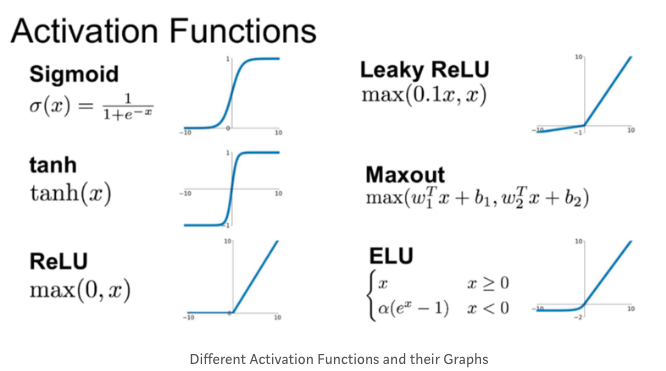

### 배치 정규화 층

In [ ]:
# 순환 층 사이에 배치 정규화 층 추가 
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(), # 배치 정규화 층 추가 
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(), # 배치 정규화 층 추가 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 24s 103ms/step - loss: 0.3567 - last_time_step_mse: 0.3541 - val_loss: 0.0668 - val_last_time_step_mse: 0.0584
Epoch 2/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0549 - last_time_step_mse: 0.0458 - val_loss: 0.0493 - val_last_time_step_mse: 0.0400
Epoch 3/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0480 - last_time_step_mse: 0.0376 - val_loss: 0.0449 - val_last_time_step_mse: 0.0357
Epoch 4/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0438 - last_time_step_mse: 0.0333 - val_loss: 0.0410 - val_last_time_step_mse: 0.0306
Epoch 5/20
219/219 [==============================] - 22s 102ms/step - loss: 0.0399 - last_time_step_mse: 0.0283 - val_loss: 0.0376 - val_last_time_step_mse: 0.0247
Epoch 6/20
219/219 [==============================] - 22s 100ms/step - loss: 0.0359 - last_time_step_mse: 0.0228 - val_loss: 0.0359 - val_last_time_step_mse: 0.0233
Epoch 7/20

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 11ms/step - loss: 0.0292 - last_time_step_mse: 0.0172


[0.029168568551540375, 0.017213867977261543]

### 층 정규화

- 층과 층 사이에 정규화 층을 추가하는 것(배치 정규화 층)이 아니라 

    메모리 셀 안에 층을 정규화 한다 

- 따라서 타임스탭마다 적용된다 

    = 순환 층 내부에서 적용 
    
    = 수평 방향으로 적용


*수직방향 : 층과 층 사이*

*수평방향 : 순환층 내부*

- 정규화를 하기 때문에 속도는 느려진다

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None) # 활성화 함수 삭제 # 활성화 함수 전에 층 정규화 하기 위해서 
        self.layer_norm = LayerNormalization() # 층 정규화 모듈 제공 # 내부에서 층 정규화
        self.activation = keras.activations.get(activation) # 활성화 함수 추가 

    # def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
    #     if inputs is not None:
    #         batch_size = tf.shape(inputs)[0]
    #         dtype = inputs.dtype
    #     return [tf.zeros([batch_size, self.state_size], dtype=dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs)) # 층 정규화 -> 활성화 함수 적용
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]), # RNN으로 감싸줘야 한다
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 79s 228ms/step - loss: 0.2894 - last_time_step_mse: 0.2863 - val_loss: 0.0727 - val_last_time_step_mse: 0.0590
Epoch 2/20
219/219 [==============================] - 50s 227ms/step - loss: 0.0660 - last_time_step_mse: 0.0529 - val_loss: 0.0568 - val_last_time_step_mse: 0.0414
Epoch 3/20
219/219 [==============================] - 49s 225ms/step - loss: 0.0543 - last_time_step_mse: 0.0378 - val_loss: 0.0503 - val_last_time_step_mse: 0.0317
Epoch 4/20
219/219 [==============================] - 49s 224ms/step - loss: 0.0488 - last_time_step_mse: 0.0315 - val_loss: 0.0456 - val_last_time_step_mse: 0.0284
Epoch 5/20
219/219 [==============================] - 49s 223ms/step - loss: 0.0448 - last_time_step_mse: 0.0281 - val_loss: 0.0419 - val_last_time_step_mse: 0.0259
Epoch 6/20
219/219 [==============================] - 49s 223ms/step - loss: 0.0412 - last_time_step_mse: 0.0254 - val_loss: 0.0391 - val_last_time_step_mse: 0.0235
Epoch 7/20

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 1s 21ms/step - loss: 0.0239 - last_time_step_mse: 0.0103


[0.023937514051795006, 0.010287589393556118]

## 15.4.2 단기 기억 문제 해결하기 

장기 메모리를 가진 여러 종류 셀 (LSTM, GRU) 등장

### LSTM

Long Short Term Memory

다음 층으로 기억을 넘길지 말지 결정

- 장기 상태에 저장할 것, 버릴 것, 읽어들일 것을 학습하는 셀
- 장기 상태에 저장, 보존, 추출
- 장기 패턴 파악에 효과적



In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), # LSTM으로 감싸기 
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 26ms/step - loss: 0.1007 - last_time_step_mse: 0.0928 - val_loss: 0.0543 - val_last_time_step_mse: 0.0334
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0496 - last_time_step_mse: 0.0290 - val_loss: 0.0398 - val_last_time_step_mse: 0.0169
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0389 - last_time_step_mse: 0.0166 - val_loss: 0.0356 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0347 - last_time_step_mse: 0.0147 - val_loss: 0.0339 - val_last_time_step_mse: 0.0163
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0327 - last_time_step_mse: 0.0137 - val_loss: 0.0313 - val_last_time_step_mse: 0.0133
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0307 - last_time_step_mse: 0.0124 - val_loss: 0.0296 - val_last_time_step_mse: 0.0118
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 9ms/step - loss: 0.0233 - last_time_step_mse: 0.0084


[0.023329611867666245, 0.008407408371567726]

### GRU

Gate Recurrent Unit

- LSTM 변종
- LSTM 간소화된 버전 -> 속도가 조금 빠름

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]), # GRU 감싸기 
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 26ms/step - loss: 0.1029 - last_time_step_mse: 0.0996 - val_loss: 0.0543 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0510 - last_time_step_mse: 0.0415 - val_loss: 0.0448 - val_last_time_step_mse: 0.0335
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0440 - last_time_step_mse: 0.0321 - val_loss: 0.0403 - val_last_time_step_mse: 0.0278
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0392 - last_time_step_mse: 0.0269 - val_loss: 0.0346 - val_last_time_step_mse: 0.0205
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0341 - last_time_step_mse: 0.0215 - val_loss: 0.0316 - val_last_time_step_mse: 0.0216
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0312 - last_time_step_mse: 0.0180 - val_loss: 0.0294 - val_last_time_step_mse: 0.0151
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0229 - last_time_step_mse: 0.0094


[0.022871725261211395, 0.009440856985747814]

### 1D 합성곱 층을 사용해서 시퀀스 처리하기 

여전히 아주 긴 길이의 데이터에 대해서는 기억하지 못하는 문제점 존재 

따라서 입력 시퀀스를 짧게 줄이기 위해 1D 합성곱을 사용한다 

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]), # 커널크기 4 # 스트라이드 2 # 입력 시퀀스를 짧게 줄인다
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2])) 
#Y_train[:, 3::2 #Y_valid[:, 3::2]
# 3부터 시작해서 끝까지 가는데 2개씩 건너뛴다 
# 데이터가 1/2배로 준다
# Conv1D에서 다운샘플링을 했기에 데이터도 줄여야 한다

Epoch 1/20
219/219 [==============================] - 8s 19ms/step - loss: 0.0891 - last_time_step_mse: 0.0853 - val_loss: 0.0455 - val_last_time_step_mse: 0.0381
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0426 - last_time_step_mse: 0.0358 - val_loss: 0.0348 - val_last_time_step_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0334 - last_time_step_mse: 0.0253 - val_loss: 0.0292 - val_last_time_step_mse: 0.0196
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0284 - last_time_step_mse: 0.0182 - val_loss: 0.0259 - val_last_time_step_mse: 0.0154
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0253 - last_time_step_mse: 0.0142 - val_loss: 0.0234 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0232 - last_time_step_mse: 0.0119 - val_loss: 0.0223 - val_last_time_step_mse: 0.0114
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_test, Y_test)

ValueError: ignored

In [ ]:
x= [i for i in range(10)]
x[3::2] # 3부터 시작해서 끝까지 가는데 2개씩 건너뛴다 

### WaveNet
- 음성을 고품질로 합성해내기 위한 모델 
- 층마다 팽창 비율을 두배로 늘리는 1D 합성곱 층


- 하위층은 단기패턴 학습
- 상위층은 장기패턴 학습


- 긴 시퀀스 모델인 오디오 데이터에서 최상의 성능을 보인다


```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate)) # dilation_rate=rate # 팽창 비율 
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.summary()

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_test, Y_test)